# Identifying Locations for a car franchise in Mumbai
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal locations for a car franchise. Specifically, this report will be targeted to stakeholders interested in opening an **Mid-range Car Showroom** in **Mumbai**, India. 

This project is about to recognise the most revenue generating places or venues to set up show-rooms for a mid ranage car of Rs.7-8 lac (approx). 
Since there are lots of localities in Mumbai we will try to detect **locations that do not meet the expectation**. Expectation being that property rate is not below Rs. 15000 per sqft. 

We will use our data science powers to generate a few most promissing location spots based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of popular venues in the city
* property rates of the localities in the city
* distance of locations from city center


Following data sources will be needed to extract/generate the required information:
* **Foursquare API** will be used to generate the list of popular vennues in Mumbai along with their address and geographical coordiantes. 
* real estate prices and rental prices locality wise from website 99acres.com 
* postal code and the respective locality names for merging the above two datasets.
* centers of localities will be generated algorithmically and approximate addresses of centers of those areas will be mapped using folium.
* number of popular venues, their categories and the distance from the cluster center will be obtained using **Foursquare API**


### Generate list of most popular places in Mumbai from FourSquare API
   

Generate the list from Foursquare API. 
Clean up the dataset (checking for null and incorrect values). 

In [1]:
import pandas as pd
import numpy as np
import geocoder # import geocoder
import geopy 
from geopy.geocoders import Nominatim
import requests
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas import json_normalize
import string
from bs4 import BeautifulSoup
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
import seaborn as sns; sns.set()
from sklearn.metrics import accuracy_score
from scipy.stats import mode
from sklearn.metrics import confusion_matrix

In [2]:
address = 'Mumbai, India'

geolocator = Nominatim(user_agent="user_explorer")
location = geolocator.geocode(address)
mum_lat = location.latitude
mum_long = location.longitude
print('The geograpical coordinate of Mumbai are {}, {}.'.format(mum_lat, mum_long))

The geograpical coordinate of Mumbai are 19.0759899, 72.8773928.


In [3]:
# API Credentials below 
key_df = pd.read_csv('k.txt')

CLIENT_ID = key_df['CLIENT_ID'].loc[0] # your Foursquare ID
CLIENT_SECRET = key_df['CLIENT_SECRET'].loc[0] # your Foursquare Secret

VERSION = '20180605' # Foursquare API version

LIMIT = 1000 # A default Foursquare API limit value

In [4]:
radius=8000   
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            mum_lat, 
            mum_long, 
            radius, 
            LIMIT)

# make the GET request
results1 = requests.get(url).json()#["response"]['groups'][0]['items']

In [5]:
# assign relevant part of JSON to venues
trend_places = results1["response"]['groups'][0]['items']

# tranform venues into a dataframe
trenddf = json_normalize(trend_places)

In [6]:
trenddf.drop(['venue.location.labeledLatLngs', 'venue.location.cc', 'venue.location.city', 'venue.location.state', 'venue.location.country', 'venue.photos.count', 'venue.photos.groups', 'venue.venuePage.id', 'venue.location.neighborhood'], axis =1, inplace = True)

In [7]:
# keep only columns that include venue name, and anything that is associated with location
#filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.')] + ['id']
filtered_columns = [col for col in trenddf.columns if col.startswith('venue.')]
trend_df = trenddf.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
trend_df['Categories'] = trend_df.apply(get_category_type, axis=1)

# clean column names by keeping only last term
trend_df.columns = [column.split('.')[-1] for column in trend_df.columns]

trend_df.head()

,id,name,address,crossStreet,lat,lng,distance,postalCode,formattedAddress,categories,Categories
0,5a21b1cea4236243c9628ad2,Hitchki,FIFC,"Bandra Kurla Complex, BKC",19.069730,72.869761,1063,400051,"[FIFC (Bandra Kurla Complex, BKC), Mumbai 4000...","[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",Bar
1,4d9b39ed2ae860fc0f5a81cb,Sofitel Mumbai BKC,"C 57 Bandra Kurla Complex, Bandra East, Mahara...",Bandra East,19.067448,72.869006,1297,400051,"[C 57 Bandra Kurla Complex, Bandra East, Mahar...","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",Hotel
2,51d2a531454ad6055f94cdce,Hamleys,Phoenix Market City Kurla,"LBS Marg,Near Kamani Junction, Kurla West",19.086655,72.889783,1763,400070,"[Phoenix Market City Kurla (LBS Marg,Near Kama...","[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",Toy / Game Store
3,50950f23e4b0578aae7a7a00,PVR Cinemas,Phoenix Market City,Kurla,19.086643,72.889839,1766,400001,"[Phoenix Market City (Kurla), Mumbai 400001, M...","[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",Movie Theater
4,4b865eeaf964a520af8731e3,Trident,"C-56, G Block, Bandra Kurla Complex,",Bandra (East),19.066808,72.867468,1461,400098,"[C-56, G Block, Bandra Kurla Complex, (Bandra ...","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",Hotel


In [8]:
trend_df.columns

Index(['id', 'name', 'address', 'crossStreet', 'lat', 'lng', 'distance',
       'postalCode', 'formattedAddress', 'categories', 'Categories'],
      dtype='object')

Extract the localities from Column 'formattedAddress' for rows which contains no Postal Codes

In [9]:
#Postal codes that are blank
trend_df[trend_df['postalCode'].isna() == True].shape

(30, 11)

In [10]:
#an instance that shows that this column contains Locality
trend_df.loc[11, 'formattedAddress'] 

['MG Road (Ghatkopar East)', 'Mumbai 400077', 'Mahārāshtra', 'India']

In [11]:
postal_code=''

def assign_postal_code(fullstring):
    substring1 = ['Bandra Kurla Complex', 'BKC', 'Bandra (East)', 'Bandra East', 'The Capital', 'Bandra E']
    substring2 = ['Santacruz East', 'Santacruz (East)', 'Santacruz E']
    substring3 = ['T2 Terminal', 'Airport', 'T1 Terminal', 'The Royal Orchid']
    substring4 = ['Ghatkopar', 'Ghatkopar E', 'Vikrant Circle']
    substring5 = ['Saki Naka','Sakinaka']
    substring6 = ['Chembur']
    substring7 = ['Bandra West', 'Bandra (West)','Waterfield Road', 'Pali Hill', 'bandra west', 'Pali', 'pali', 'Bandra W']
    substring8 = ['Khar West', 'Khar (West)', 'Khar W']
    substring9 = ['Mithibai College']
    substring10 = ['Powai', 'powai']
    substring11 = ['Juhu', 'juhu']
    substring12 = ['Peshawri Restaurant']
    substring13 = ['Andheri E', 'Andheri (east)', 'Andheri (East)', 'Andheri e']
    substring14 = ['Phoenix Market City']
    global postal_code
    for item in substring1:    
        if item.upper().lower() in fullstring.upper().lower():
            postal_code = '400051'
    for item in substring2:    
        if item.upper().lower() in fullstring.upper().lower():
            postal_code = '400055'        
    for item in substring3:    
        if item.upper().lower() in fullstring.upper().lower():
            postal_code = '400099'
    for item in substring4:    
        if item.upper().lower() in fullstring.upper().lower():
            postal_code = '400077'
    for item in substring5:    
        if item.upper().lower() in fullstring.upper().lower():
            postal_code = '400072'
    for item in substring6:    
        if item.upper().lower() in fullstring.upper().lower():
            postal_code = '400071'  
    for item in substring7:    
        if item.upper().lower() in fullstring.upper().lower():
            postal_code = '400050'  
    for item in substring8:    
        if item.upper().lower() in fullstring.upper().lower():
            postal_code = '400052'
    for item in substring9:    
        if item.upper().lower() in fullstring.upper().lower():
            postal_code = '400056'
    for item in substring10:    
        if item.upper().lower() in fullstring.upper().lower():
            postal_code = '400076'
    for item in substring11:    
        if item.upper().lower() in fullstring.upper().lower():
            postal_code = '400049'
    for item in substring12:    
        if item.upper().lower() in fullstring.upper().lower():
            postal_code = '400047'
    for item in substring13:    
        if item.upper().lower() in fullstring.upper().lower():
            postal_code = '400069'
    for item in substring14:    
        if item.upper().lower() in fullstring.upper().lower():
            postal_code = '400070'
    return postal_code


for i in range(len(trend_df['postalCode'])):
        if type(trend_df.loc[i, 'postalCode']) == float:
            fullstring = trend_df.loc[i, 'formattedAddress'][0]
            postal_code=''
            trend_df.loc[i, 'postalCode'] = assign_postal_code(fullstring)
        elif type(trend_df.loc[i, 'postalCode']) == str:
            if trend_df.loc[i, 'postalCode'] == "":
                fullstring = trend_df.loc[i, 'formattedAddress'][0]
                postal_code=''
                trend_df.loc[i, 'postalCode'] = assign_postal_code(fullstring)
            elif len(trend_df.loc[i, 'postalCode'].split(' ')) == 2:
                trend_df.loc[i, 'postalCode'] = "".join(trend_df.loc[i, 'postalCode'].split())

In [12]:
#Now check how many of the postal code rows are still blank
trend_df[trend_df['postalCode'] == ""].head()

,id,name,address,crossStreet,lat,lng,distance,postalCode,formattedAddress,categories,Categories
20,4dc657591f6ef43b8a2cdf4a,The Royal Orchid,NaN,NaN,19.061739,72.901596,3000,,"[Mumbai, Mahārāshtra, India]","[{'id': '4bf58dd8d48988d142941735', 'name': 'A...",Asian Restaurant
94,56be18ce498ebf522c32ad58,TrueTrammTrunk,NaN,NaN,19.103452,72.831413,5722,,"[Mumbai, Mahārāshtra, India]","[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",Bar
97,4c13b008a9c220a14f23569d,Naturals,NaN,Ghatkopar,19.080181,72.908256,3280,,"[Mahārāshtra, India]","[{'id': '4bf58dd8d48988d1c9941735', 'name': 'I...",Ice Cream Shop


<b>Now manually populate the remaiing blank postalcode as they are very few and correct the incorrect ones.</b>

In [14]:
a = trend_df[trend_df['name'] == "The Royal Orchid"].index
#the postal code and since the postal code is available, I assigned the value 
trend_df.loc[a, 'postalCode'] = "400099"


c = trend_df[trend_df['name'] == "Naturals"].index
#after checking the 'crossStreet' of Naturals we know the location and set the postal code of that location in the resp. column
trend_df.loc[c, 'postalCode'] = "400077"


c = trend_df[trend_df['name'] == "TrueTrammTrunk"].index
#after checking the 'crossStreet' of Naturals we know the location and set the postal code of that location in the resp. column
trend_df.loc[c, 'postalCode'] = "400049"

d = trend_df[trend_df['postalCode'] == "4000052"].index
#the above postal code is incorrect; does not exists
trend_df.loc[d, 'postalCode'] = "400052"

Check which postal code are not valid and make the necessary changes. Also check the postal codes againsts whom real estate prices are not avaialble. They are available for the more broadly used and referred Localities.

In [15]:
e = trend_df[trend_df['postalCode'] == "400001"].index
#this postal code is invalid so manually check and replace it with the correct one
trend_df.loc[e, 'postalCode'] = "400070"

f = trend_df[trend_df['postalCode'] == "400040"].index
#this postal code is incorrect; replace it with the correct one
trend_df.loc[f, 'postalCode'] = "400050"

g = trend_df[trend_df['postalCode'] == "400074"].index
#this postal code does not exists; replace it with the correct one
trend_df.loc[g, 'postalCode'] = "400071"

<b>Plot the venues on the graph to visulaize the location</b>

In [16]:
import folium

# define the world map centered around Mumbai with a low zoom level
mumbai_map = folium.Map(location=[mum_lat, mum_long], zoom_start=12, fig_size=(11, 15))

#mumbai_map

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, name in zip(trend_df.lat, trend_df.lng, trend_df.name):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            popup=name,
            color='yellow',
            fill=True,
            fill_color='black',
            fill_opacity=0.6
        )
    )

# add incidents to map
mumbai_map.add_child(incidents)

**Observations:** The pincode for Sahar (Airport Area) is 400099 but the real estate prices of these areas are normally listed under Andheri (East) and this is verified as per the locations on the map above. The point JW Cafe is located so near to the other points in the Sahar. So we will update the pincodes 400099 to 400069 in the following points. Also pincode 400037 falls under Wadala area where real estate prices are concerned, hence the change.

In [17]:
lt_ind = trend_df[trend_df['postalCode'] == '400099'].index
lt_ind

Int64Index([9, 14, 15, 16, 20, 21, 52, 53], dtype='int64')

In [18]:
for index in lt_ind:
    trend_df.loc[index, 'postalCode'] = '400069'

In [19]:
g = trend_df[trend_df['postalCode'] == "400037"].index
#this postal code does exists but the real estate prices are not available for Antop Hill but under Wadala area.
trend_df.loc[g, 'postalCode'] = "400031"

In [20]:
trend_df['postalCode'].value_counts()

400050    18
400051    11
400069    10
400077    10
400049     8
400071     7
400076     6
400052     5
400070     4
400086     4
400057     3
400019     3
400089     2
400072     1
400022     1
400055     1
400031     1
400058     1
400056     1
400059     1
400098     1
400080     1
Name: postalCode, dtype: int64

#### Now introduce a column post office to normalize the areas

We will do this as we have to populate the area real estate prices which will give us an idea whether the people staying near by can afford a mid-range car. 
For this we wil scrap a website and then populate another column in dataframe trend_df

In [21]:
#Specify the URL from which the data has to be extracted
url="https://mumbai7.com/postal-codes-in-mumbai/"

In [22]:
headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:60.0) Gecko/20100101 Firefox/60.0"
}

#to request the text from the webpage 
website_url = requests.get(url, headers=headers).text
soup = BeautifulSoup(website_url, 'lxml')
#print(soup.prettify()) 

#Specify the particular table by mentioning the classs. Class name is provide in the Source Code of the web-page, 
    #which is in HTML.  
#my_table = soup.find('table',{'class':'wikitable sortable'})
my_table = soup.find('table')

#Use findAll to identify the tr, td and pass the values of the table cell in the List. Remove the '\n' from the values 
    #before they are appended to appropriate List.  
Postoffice = []
Pincode = []
for rows in my_table.findAll('tr'):
    cells = rows.findAll('td')
    if len(cells)==3:
        Postoffice.append((cells[1].find(text=True)).rstrip('\n'))
        Pincode.append((cells[2].find(text=True)).rstrip('\n'))

Pass tha data colleted from the website into a dataframe

In [23]:
df = pd.DataFrame(Postoffice, columns=['Locality'])
df['postalCode'] = Pincode
print('Number of rows and Columns in the table are:', df.shape)
df.head()

Number of rows and Columns in the table are: (157, 2)


,Locality,postalCode
0,August Kranti Marg,400036
1,Aarey Milk Colony,400065
2,Andheri (East),400069
3,Andheri (West),400058
4,Antop Hill,400037


#### Amend the post office names with the names more widely known; easier to merge it with other dataset

We have to do this as we have to ensure that the locality names are in order with the other pricing dataset from 99acres.com. The real estate prices are not available as per the post office names. They are more in line with the loclities. Hence we will change the name of locality of few, not so famous ones, with the ones against whom real estate prices are normally available. As these changes are very few, we will manually do the same. Rarely, the spelling are also needed to be corrected. 

In [24]:
ind = df[df['Locality']=='Rajawadi'].index
#Rajawadi is more known as Ghakopar (East)
df.loc[ind, 'Locality'] = 'Ghatkopar (East)'

ind1 = df[df['Locality']=='I I T Mumbai'].index
#Though the postoffice name is I I T Mumbai but it is more known as Powai
df.loc[ind1, 'Locality'] = 'Powai'
#df[df['Locality']=='Powai']

ind2 = df[df['Locality']=='Vidyanagari'].index
#We will change the spelling as is used in pricing dataset to bring some standardization
df.loc[ind2, 'Locality'] = 'Vidya Nagari'
#df[df['Locality']=='Vidya Nagari']

ind3 = df[df['Locality']=='Saki Naka'].index
#We will change the spelling as is used in pricing dataset to bring some standardization
df.loc[ind3, 'Locality'] = 'Sakinaka'
#df[df['Locality']=='Sakinaka']

ind4 = df[df['Locality']=='Kurla'].index
#this post office is in Kurla (West) and also mentioned in the pricing dataset as Kurla (West); hence the change  
df.loc[ind4, 'Locality'] = 'Kurla (West)'
#df[df['Locality']=='Kurla (West)']

ind5 = df[df['Locality']=='Sion'].index
#this post office is in Sion (West) and also mentioned in the pricing dataset as Sion (West); hence the change 
df.loc[ind5, 'Locality'] = 'Sion (West)'
#df[df['Locality']=='Sion (West)']

In [25]:
trend_df = trend_df.merge(df, how="left", on='postalCode')

In [26]:
trend_df.shape

(100, 12)

### Extract current real estate residential prices from 99acres.com

In [27]:
#Specify the URL from which the data regarding the real estate prices has to be extracted
url1="https://www.99acres.com/property-rates-and-price-trends-in-mumbai"

In [28]:
#to request the text from the webpage 
website_url = requests.get(url1, headers=headers).text
soup = BeautifulSoup(website_url, 'lxml')

#Specify the particular table by mentioning the classs. Class name is provide in the Source Code of the web-page, 
    #which is in HTML.  
my_table = soup.find('table',{'class':'prTble'})

In [29]:
#Use findAll to identify the tr, td and pass the values of the table cell in the List. Remove the '\n' from the values 
    #and other unwanted parts in the table before they are appended to appropriate List.  

Locality = []
MinPrice_psf = []
MaxPrice_psf = []
Qtr_changepc = []
MinIB_Rental = []
MaxIB_Rental = []
MinIIB_Rental = []
MaxIIB_Rental = []
MinIIIB_Rental = []
MaxIIIB_Rental = []

for rows in my_table.findAll('tr'):
    cells = rows.findAll('td')
    if len(cells)==7:
        Locality.append((cells[0].find(text=True)).rstrip('\n'))
        
        st1 = cells[1].text.replace('<td><span class="WebRupeesmall">Rs. </span>', '')
        st2 = st1.replace("/sq. ft.", "")
        if st2.replace("Rs. ", "") != '-':
            st3 = st2.replace("Rs. ", "").split(" - ")
            MinPrice_psf.append(st3[0].replace(",", ''))
            MaxPrice_psf.append(st3[1].replace(",", ''))
        else:
            MinPrice_psf.append(0)
            MaxPrice_psf.append(0)
  

        st4 = (cells[2].find(text=True).rstrip('\n')).replace("%", "").strip()
        if st4 != "":
            if st4 != '-':
                Qtr_changepc.append(st4)
            elif st4 == '-':
                Qtr_changepc.append(0)
        else:
            Qtr_changepc.append(0)

        st5 = cells[4].text.replace('<td class="bGrey"><span class="WebRupeesmall">Rs. </span>', '')
        st6 = st5.replace("Rs. ", "")
        if st6 != '-':
            st7 = st6.replace("Rs. ", "").split(" - ")
            MinIB_Rental.append(st7[0].replace(",", ''))
            MaxIB_Rental.append(st7[1].replace(",", ''))
        else:
            MinIB_Rental.append(0)
            MaxIB_Rental.append(0)
    
        sa = cells[5].text.replace('<td class="bGrey"><span class="WebRupeesmall">Rs. </span>', '')
        sb = sa.replace("Rs. ", "").strip()
        if sb != '-':
            sc = sb.replace("Rs. ", "").split(" - ")
            MinIIB_Rental.append(sc[0].replace(",", ''))
            MaxIIB_Rental.append(sc[1].replace(",", ''))
        elif sb == '-':
            MinIIB_Rental.append(0)
            MaxIIB_Rental.append(0)
            
        sd = cells[6].text.replace('<td class="bGrey"><span class="WebRupeesmall">Rs. </span>', '')
        se = sd.replace("Rs. ", "")
        if se != '-':
            sf = se.replace("Rs. ", "").split(" - ")
            MinIIIB_Rental.append(sf[0].replace(",", ''))
            MaxIIIB_Rental.append(sf[1].replace(",", ''))
        else:
            MinIIIB_Rental.append(0)
            MaxIIIB_Rental.append(0)
       

In [30]:
#Push the above lists to relevant columns and prepare the dataframe 
pricedf = pd.DataFrame(Locality, columns=['Locality'])
pricedf['MinPrice psf'] = MinPrice_psf
pricedf['MaxPrice psf'] = MaxPrice_psf
pricedf['Qtr change'] = Qtr_changepc
pricedf['Min IBHK Rental'] = MinIB_Rental
pricedf['Max IBHK Rental'] = MaxIB_Rental
pricedf['Min IIBHK Rental'] = MinIIB_Rental
pricedf['Max IIBHK Rental'] = MaxIIB_Rental
pricedf['Min IIIBHK Rental'] = MinIIIB_Rental
pricedf['Max IIIBHK Rental'] = MaxIIIB_Rental
print('Number of rows and Columns in the table are:', pricedf.shape)
pricedf.head()

Number of rows and Columns in the table are: (755, 10)


,Locality,MinPrice psf,MaxPrice psf,Qtr change,Min IBHK Rental,Max IBHK Rental,Min IIBHK Rental,Max IIBHK Rental,Min IIIBHK Rental,Max IIIBHK Rental
0,Anand Nagar,8288,9265,2.99,10975,12347,15820,18697,20995,29835
1,Balkum,9138,10625,4.93,12464,15341,17552,21063,27898,30324
2,Balkum Pada,8542,9690,0,10547,13423,0,0,0,0
3,Bhayandarpada,7522,8840,7.03,9383,12346,11723,13921,0,0
4,Brahmand,8585,9818,4.39,11980,13755,15300,18360,24936,27311


Make any necessary changes in the names of Locality columns to smoothen the merge

In [31]:
#to normalize the name for smooth merging 
in1 = pricedf[pricedf['Locality']=='Ghatkopar West'].index
for index in in1:
    pricedf.loc[in1, 'Locality'] = 'Ghatkopar (West)'
    

in2 = pricedf[pricedf['Locality']=='Kurla (west)'].index
for index in in2:
    pricedf.loc[in2, 'Locality'] = 'Kurla (West)'   

In [32]:
pricedf[pricedf['Locality']=='Tilak Nagar']

,Locality,MinPrice psf,MaxPrice psf,Qtr change,Min IBHK Rental,Max IBHK Rental,Min IIBHK Rental,Max IIBHK Rental,Min IIIBHK Rental,Max IIIBHK Rental
422,Tilak Nagar,14450,16660,-1.35,19550,23800,30297,34284,0,0
750,Tilak Nagar,14110,16320,-0.56,21379,25388,29622,34680,42691,47898


In [33]:
#Since there are 2 rows of Tilak Nagar - one in Mumbai and another one in Harbour, we will drop the later as it is in Habour.
pricedf.drop(index=750, axis=0, inplace=True)

#check if the drop was sucessful
pricedf[pricedf['Locality']=='Tilak Nagar']

,Locality,MinPrice psf,MaxPrice psf,Qtr change,Min IBHK Rental,Max IBHK Rental,Min IIBHK Rental,Max IIBHK Rental,Min IIIBHK Rental,Max IIIBHK Rental
422,Tilak Nagar,14450,16660,-1.35,19550,23800,30297,34284,0,0


Change the type of columns which contain real estate pricing per sq ft and rental pricing  

In [34]:
pricedf.astype({'MinPrice psf': 'int64', 'MaxPrice psf': 'int64', 'Min IBHK Rental': 'int64', 'Max IBHK Rental': 'int64', 'Min IIBHK Rental': 'int64', 'Max IIBHK Rental': 'int64', 'Min IIIBHK Rental': 'int64', 'Max IIIBHK Rental': 'int64'}).dtypes

Locality             object
MinPrice psf          int64
MaxPrice psf          int64
Qtr change           object
Min IBHK Rental       int64
Max IBHK Rental       int64
Min IIBHK Rental      int64
Max IIBHK Rental      int64
Min IIIBHK Rental     int64
Max IIIBHK Rental     int64
dtype: object

Update the 'MinPrice psf' and 'MAxPrice psf' columns in pricedf as it is one of the Locality with maximum number of footfalls. As Upon analysis, we realise that there is no info on one of the Locality 'Ghatkopar (East)' - A simple google search will help in fetching the data and then we update the same here.  And since this is just one case, we will manually update it.

In [35]:
#update the prices in pricedf(dataframe which contains data from website 99acres) so as to have standard across dataframes
pricedf[pricedf['Locality']=='Ghatkopar (East)']
ind11 = pricedf[pricedf['Locality']=='Ghatkopar (East)'].index
ind11
pricedf.loc[ind11, 'MinPrice psf'] = 16011
pricedf.loc[ind11, 'MaxPrice psf'] = 27760

Now merge the trend_df dataframe with the dataframe prepared from pricedf dataframe.

In [36]:
trend_df.shape

(100, 12)

In [37]:
trendpricedf = trend_df.merge(pricedf, how="left", on='Locality')

In [38]:
trendpricedf.shape

(100, 21)

## Methodology <a name="methodology"></a>

Now that the dataset is finally ready, we will calculate the mean of Minimum real estate per sqft and maximum real estate per sqft. We wil also calculate the correlation between the real estate prices and rental rates. Objective being, if the correlation is high then we can safely ignore the rental rates in the model and not complicate it.  

After deciding the column to be used in the model, we will then perform k-means Clustering model. But first, we will calculate the number of cluster to be created using the elbow method. 

The next step will be to find the best location in and around the coordinates with k-means algorithm. The cluster centers the model generates will then to plotted on the map and then the same coordinates will be passed to Foursquare API to find the popular venues within a radius of 500 metres and their category. This is to gage how viable the clsuter centers are to set shop.

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First we will calculate the mean and then we will generate the correlation. But first, sort the list where MinPricepsf or MaxPricepsf is less than Rs 15000 per sqft.

In [39]:
#Calculate the average of retail price per sqft to elimate the areas whose average retail is <= Rs 16000 psf 
    #and minprice psf is also less than Rs15k psf 
trendpricedf['AverageRetailPrice'] = trendpricedf[['MinPrice psf', 'MaxPrice psf']].astype(float).mean(axis=1)
trendpricedf['AverageRetailPrice'].round(decimals = 2)
trendpricedf.head()

,id,name,address,crossStreet,lat,lng,distance,postalCode,formattedAddress,categories,...,MinPrice psf,MaxPrice psf,Qtr change,Min IBHK Rental,Max IBHK Rental,Min IIBHK Rental,Max IIBHK Rental,Min IIIBHK Rental,Max IIIBHK Rental,AverageRetailPrice
0,5a21b1cea4236243c9628ad2,Hitchki,FIFC,"Bandra Kurla Complex, BKC",19.069730,72.869761,1063,400051,"[FIFC (Bandra Kurla Complex, BKC), Mumbai 4000...","[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",...,25628,30472,0,21206,26311,58783,69156,99450,135150,28050.0
1,4d9b39ed2ae860fc0f5a81cb,Sofitel Mumbai BKC,"C 57 Bandra Kurla Complex, Bandra East, Mahara...",Bandra East,19.067448,72.869006,1297,400051,"[C 57 Bandra Kurla Complex, Bandra East, Mahar...","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",...,25628,30472,0,21206,26311,58783,69156,99450,135150,28050.0
2,51d2a531454ad6055f94cdce,Hamleys,Phoenix Market City Kurla,"LBS Marg,Near Kamani Junction, Kurla West",19.086655,72.889783,1763,400070,"[Phoenix Market City Kurla (LBS Marg,Near Kama...","[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",...,13005,15810,-2.58,18766,24199,31957,38972,48063,55888,14407.5
3,50950f23e4b0578aae7a7a00,PVR Cinemas,Phoenix Market City,Kurla,19.086643,72.889839,1766,400070,"[Phoenix Market City (Kurla), Mumbai 400001, M...","[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",...,13005,15810,-2.58,18766,24199,31957,38972,48063,55888,14407.5
4,4b865eeaf964a520af8731e3,Trident,"C-56, G Block, Bandra Kurla Complex,",Bandra (East),19.066808,72.867468,1461,400098,"[C-56, G Block, Bandra Kurla Complex, (Bandra ...","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",...,20485,23375,0,27030,33660,33928,41467,0,0,21930.0


In [40]:
#extract the postal codes which have MinPrice psf < Rs15k and Avergaeretailprice < Rs 16k.

ind_lst = trendpricedf[(trendpricedf['MinPrice psf'].astype(int) < 15000) & (trendpricedf.AverageRetailPrice < 16000)]['postalCode'].unique()
ind_lst

array(['400070', '400089', '400072', '400080'], dtype=object)

In [41]:
#Now delete the records with the postal codes in ind_lst

trendpricedf = trendpricedf[~trendpricedf.postalCode.isin(ind_lst)]
trendpricedf.shape

(92, 22)

<b>Calculate the correlation between the retail prices and rental rates.</b>

In [42]:
trendpricedf['MinPrice psf'].astype(int).corr(trendpricedf['Min IBHK Rental'].astype(int))

0.8679278951650881

**Observations:** The above result shows that there is a positive correlation between minimum retail prices and minimum rental prices and the value is very high. So the conclusion is taht it will make no difference if we include or exclude the rental prices in the clustering model. 

### Perform Clustering to generate clusters

First, create a new dataframe that has the relevant columns to perform Clustering.

In [43]:
trendpricedf.columns

Index(['id', 'name', 'address', 'crossStreet', 'lat', 'lng', 'distance',
       'postalCode', 'formattedAddress', 'categories', 'Categories',
       'Locality', 'MinPrice psf', 'MaxPrice psf', 'Qtr change',
       'Min IBHK Rental', 'Max IBHK Rental', 'Min IIBHK Rental',
       'Max IIBHK Rental', 'Min IIIBHK Rental', 'Max IIIBHK Rental',
       'AverageRetailPrice'],
      dtype='object')

In [44]:
trprclusterdf = trendpricedf[['id', 'name', 'lat', 'lng', 'distance', 'postalCode', 'Categories', 'Locality', 'MinPrice psf', 'MaxPrice psf', 'Min IBHK Rental', 'Max IBHK Rental', 'Min IIBHK Rental',
       'Max IIBHK Rental', 'Min IIIBHK Rental', 'Max IIIBHK Rental' , 'AverageRetailPrice']]
trprclusterdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 0 to 99
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  92 non-null     object 
 1   name                92 non-null     object 
 2   lat                 92 non-null     float64
 3   lng                 92 non-null     float64
 4   distance            92 non-null     int64  
 5   postalCode          92 non-null     object 
 6   Categories          92 non-null     object 
 7   Locality            92 non-null     object 
 8   MinPrice psf        92 non-null     object 
 9   MaxPrice psf        92 non-null     object 
 10  Min IBHK Rental     92 non-null     object 
 11  Max IBHK Rental     92 non-null     object 
 12  Min IIBHK Rental    92 non-null     object 
 13  Max IIBHK Rental    92 non-null     object 
 14  Min IIIBHK Rental   92 non-null     object 
 15  Max IIIBHK Rental   92 non-null     object 
 16  AverageRet

In [45]:
trprcltrdf = trprclusterdf #make a copy
trpr_grouped_clustering = trprcltrdf.drop(columns=['id', 'name', 'postalCode', 'Categories', 'Locality', 'distance', 'MinPrice psf' , 'MaxPrice psf', 'Min IBHK Rental', 'Max IBHK Rental', 'Min IIBHK Rental',
       'Max IIBHK Rental', 'Min IIIBHK Rental', 'Max IIIBHK Rental'], axis = 1)
trpr_grouped_clustering.head()

,lat,lng,AverageRetailPrice
0,19.069730,72.869761,28050.0
1,19.067448,72.869006,28050.0
4,19.066808,72.867468,21930.0
5,19.063457,72.861576,28050.0
6,19.060443,72.866020,28050.0


Find the most appropriate number of clusters that should be created.

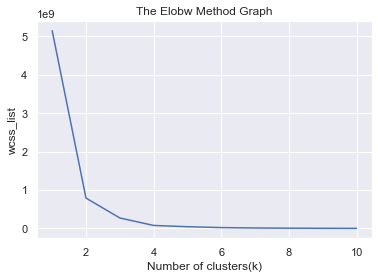

In [46]:
wcss_list= []
for i in range(1, 11):  
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state= 0, n_init=12)  
    kmeans.fit(trpr_grouped_clustering)  
    wcss_list.append(kmeans.inertia_)  
plt.plot(range(1, 11), wcss_list)  
plt.title('The Elobw Method Graph')  
plt.xlabel('Number of clusters(k)')  
plt.ylabel('wcss_list')  
plt.show()  

In [47]:
# set number of clusters as the graph suggests
kclusters = 3

# run k-means clustering and fit the model
kmeans = KMeans(n_clusters=kclusters, random_state=12).fit(trpr_grouped_clustering)

#predict the model
cluster = kmeans.fit_predict(trpr_grouped_clustering)  

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 0])

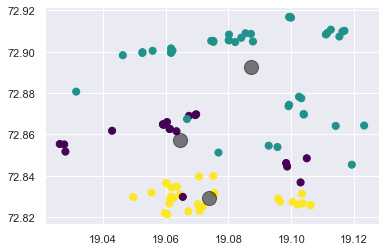

In [48]:
#Plot a graph to visualize the result along with the cluster center point.
plt.scatter(trpr_grouped_clustering['lat'], trpr_grouped_clustering['lng'], c=cluster, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [49]:
# add clustering labels to the existing dataset
trprcltrdf.insert(0, 'ClusterLabels', kmeans.labels_)
centers = kmeans.cluster_centers_
labels = kmeans.labels_
print(centers)

[[1.90645546e+01 7.28571406e+01 2.81707105e+04]
 [1.90871920e+01 7.28927928e+01 1.86904048e+04]
 [1.90737394e+01 7.28295336e+01 3.50516129e+04]]


In [50]:
kmeans.cluster_centers_.shape #results indicate that there are 3 clusters in 3 dimensions

(3, 3)

In [51]:
#to see what cluster center looks like
fig, ax = plt.subplots(3, 1, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(3, 3, 1)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [52]:
#find the accuracy of the 
labels1 = np.zeros_like(cluster)
for i in range(10):
    mask = (cluster == i)
    labels1[mask] = mode(trprcltrdf.ClusterLabels[mask])[0]

accuracy_score(trprcltrdf.ClusterLabels, labels1)

1.0

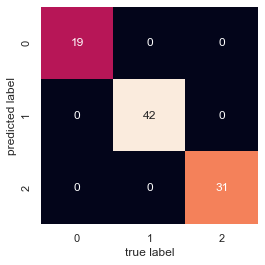

In [53]:
#With just a simple k-means algorithm, we discovered the correct grouping for 100% of the input digits! 
#Let's check the confusion matrix for this:
mat = confusion_matrix(trprcltrdf.ClusterLabels, labels1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [54]:
trprcltrdf.shape

(92, 18)

Visulaize the resulting dataset:

In [55]:
# create map
map_clusters = folium.Map(location=[mum_lat, mum_long], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(trprcltrdf['lat'], trprcltrdf['lng'], trprcltrdf['Locality'], trprcltrdf['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine the Clusters

<b>Cluster 1</b>

In [56]:
trprcltrdf[trprcltrdf['ClusterLabels'] == 0].shape

(19, 18)

In [57]:
trprcltrdf.loc[trprcltrdf['ClusterLabels'] == 0, trprcltrdf.columns[[0] + [2] + list(range(5, trprcltrdf.shape[1]))]]

,ClusterLabels,name,distance,postalCode,Categories,Locality,MinPrice psf,MaxPrice psf,Min IBHK Rental,Max IBHK Rental,Min IIBHK Rental,Max IIBHK Rental,Min IIIBHK Rental,Max IIIBHK Rental,AverageRetailPrice
0,0,Hitchki,1063,400051,Bar,Bandra (East),25628,30472,21206,26311,58783,69156,99450,135150,28050.0
1,0,Sofitel Mumbai BKC,1297,400051,Hotel,Bandra (East),25628,30472,21206,26311,58783,69156,99450,135150,28050.0
5,0,Starbucks Coffee Capital,2171,400051,Coffee Shop,Bandra (East),25628,30472,21206,26311,58783,69156,99450,135150,28050.0
6,0,MCA Club,2104,400051,Gym Pool,Bandra (East),25628,30472,21206,26311,58783,69156,99450,135150,28050.0
7,0,Yauatcha,2245,400051,Dim Sum Restaurant,Bandra (East),25628,30472,21206,26311,58783,69156,99450,135150,28050.0
12,0,Toast And Tonic,2274,400051,Bar,Bandra (East),25628,30472,21206,26311,58783,69156,99450,135150,28050.0
19,0,CinCin,2254,400051,Italian Restaurant,Bandra (East),25628,30472,21206,26311,58783,69156,99450,135150,28050.0
23,0,Guru Kripa,4026,400022,Indian Restaurant,Sion (West),22185,26180,24556,30014,0,0,0,0,24182.5
24,0,PizzaExpress BKC,1115,400051,Pizza Place,Bandra (East),25628,30472,21206,26311,58783,69156,99450,135150,28050.0
25,0,O Pedro,2293,400051,Goan Restaurant,Bandra (East),25628,30472,21206,26311,58783,69156,99450,135150,28050.0


<b>Cluster 2</b>

In [58]:
trprcltrdf[trprcltrdf['ClusterLabels'] == 1].shape

(42, 18)

In [59]:
trprcltrdf.loc[trprcltrdf['ClusterLabels'] == 1, trprcltrdf.columns[[0] + [2] + list(range(5, trprcltrdf.shape[1]))]]

,ClusterLabels,name,distance,postalCode,Categories,Locality,MinPrice psf,MaxPrice psf,Min IBHK Rental,Max IBHK Rental,Min IIBHK Rental,Max IIBHK Rental,Min IIIBHK Rental,Max IIIBHK Rental,AverageRetailPrice
4,1,Trident,1461,400098,Hotel,Vidya Nagari,20485,23375,27030,33660,33928,41467,0,0,21930.0
9,1,JW Marriott Mumbai Sahar,2952,400069,Hotel,Andheri (East),15512,17935,21505,25245,34101,39652,45591,53880,16723.5
10,1,Grand Hyatt,2749,400055,Hotel,Santacruz (East),19252,22100,24310,28050,37570,44072,54060,61200,20676.0
11,1,Khau Galli,2992,400077,Food Truck,Ghatkopar (East),16011,27760,22759,26805,32725,39419,52594,67788,21885.5
14,1,Peshawari,3211,400069,Indian Restaurant,Andheri (East),15512,17935,21505,25245,34101,39652,45591,53880,16723.5
15,1,Emirates First and Business Class Checkin,2607,400069,Airport Service,Andheri (East),15512,17935,21505,25245,34101,39652,45591,53880,16723.5
16,1,ITC Maratha,3225,400069,Hotel,Andheri (East),15512,17935,21505,25245,34101,39652,45591,53880,16723.5
17,1,J W Cafe,3030,400069,Restaurant,Andheri (East),15512,17935,21505,25245,34101,39652,45591,53880,16723.5
20,1,The Royal Orchid,3000,400069,Asian Restaurant,Andheri (East),15512,17935,21505,25245,34101,39652,45591,53880,16723.5
21,1,Starbucks: A Tata Alliance,2616,400069,Coffee Shop,Andheri (East),15512,17935,21505,25245,34101,39652,45591,53880,16723.5


<b>Cluster 3</b>

In [60]:
trprcltrdf[trprcltrdf['ClusterLabels'] == 2].shape

(31, 18)

In [61]:
trprcltrdf.loc[trprcltrdf['ClusterLabels'] == 2, trprcltrdf.columns[[0] + [2] + list(range(5, trprcltrdf.shape[1]))]]

,ClusterLabels,name,distance,postalCode,Categories,Locality,MinPrice psf,MaxPrice psf,Min IBHK Rental,Max IBHK Rental,Min IIBHK Rental,Max IIBHK Rental,Min IIIBHK Rental,Max IIIBHK Rental,AverageRetailPrice
30,2,Escobar,4653,400050,Lounge,Bandra (West),32598,38165,42330,51000,64600,78200,106080,136000,35381.5
32,2,Bastian,4689,400050,Seafood Restaurant,Bandra (West),32598,38165,42330,51000,64600,78200,106080,136000,35381.5
33,2,Starbucks,4802,400052,Coffee Shop,Khar,31322,36168,38250,46410,63750,79050,114009,153843,33745.0
34,2,Bombay Coffee House,4707,400050,Coffee Shop,Bandra (West),32598,38165,42330,51000,64600,78200,106080,136000,35381.5
35,2,Bombay Salad Co.,5047,400050,Salad Place,Bandra (West),32598,38165,42330,51000,64600,78200,106080,136000,35381.5
38,2,Chocolateria San Churro,4778,400050,Dessert Shop,Bandra (West),32598,38165,42330,51000,64600,78200,106080,136000,35381.5
40,2,Willingdon Catholic Gymkhana,3936,400052,Gym / Fitness Center,Khar,31322,36168,38250,46410,63750,79050,114009,153843,33745.0
44,2,Punjab Sweet House And Restaurant,5263,400050,Indian Restaurant,Bandra (West),32598,38165,42330,51000,64600,78200,106080,136000,35381.5
45,2,Indigo Deli,5236,400050,Deli / Bodega,Bandra (West),32598,38165,42330,51000,64600,78200,106080,136000,35381.5
46,2,Soho House,5541,400049,Club House,Juhu,32640,37612,35700,40800,61370,77520,103075,129170,35126.0


### Extract coordinates from cluster center; Use Foursquare API to list popular places nearby.

In [62]:
print('The three coordinates are:')
print('First coordiantes are:', centers[0])
print('Second coordinates are:', centers[1])
print('Third coordinates are:', centers[2])

The three coordinates are:
First coordiantes are: [[1.90645546e+01]
 [7.28571406e+01]
 [2.81707105e+04]]
Second coordinates are: [[   19.08719197]
 [   72.89279283]
 [18690.4047619 ]]
Third coordinates are: [[1.90737394e+01]
 [7.28295336e+01]
 [3.50516129e+04]]


In [63]:
#specify the urls for Foursquare API
area1_lat = str(centers[0][0]).lstrip('[').rstrip(']')
area1_long = str(centers[0][1]).lstrip('[').rstrip(']')
area2_lat = str(centers[1][0]).lstrip('[').rstrip(']')
area2_long = str(centers[1][1]).lstrip('[').rstrip(']')
area3_lat = str(centers[2][0]).lstrip('[').rstrip(']')
area3_long = str(centers[2][1]).lstrip('[').rstrip(']')
lim=100
rad=500   


url1 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            area1_lat, 
            area1_long, 
            rad, 
            lim)

url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            area2_lat, 
            area2_long, 
            rad, 
            lim)

url3 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            area3_lat, 
            area3_long, 
            rad, 
            lim)

In [64]:
#map the cluster centers
latlon = [ (area1_lat, area1_long), (area2_lat, area2_long), (area3_lat, area3_long)]
mapit = folium.Map( location=[mum_lat, mum_long], zoom_start=13 )
for coord in latlon:
    folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de', radius=8 ).add_to( mapit )

mapit

In [65]:
# make the GET request
#for first coordinate
list1 = requests.get(url1).json()#["response"]['groups'][0]['items']

#for second coordinate
list2 = requests.get(url2).json()#["response"]['groups'][0]['items']

#for third coordinate
list3 = requests.get(url3).json()#["response"]['groups'][0]['items']

In [66]:
# assign relevant part of JSON to venues for first coordinate
exp_place1 = list1["response"]['groups'][0]['items']

# tranform venues into a dataframe
expl1 = json_normalize(exp_place1)
print('Number of rows & columns:', expl1.shape)
expl1

Number of rows & columns: (7, 20)


,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.cc,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.crossStreet,venue.location.postalCode,venue.location.city,venue.location.state
0,e-0-546f25c5498e2d4d056ad6eb-0,0,"[{'summary': 'This spot is popular', 'type': '...",546f25c5498e2d4d056ad6eb,Starbucks Coffee Capital,The Capital,19.063457,72.861576,"[{'label': 'display', 'lat': 19.06345693697131...",482,IN,India,"[The Capital, India]","[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",0,[],NaN,NaN,NaN,NaN
1,e-0-544f5a12498e57364d5c2fcb-1,0,"[{'summary': 'This spot is popular', 'type': '...",544f5a12498e57364d5c2fcb,Theobrama,"Ground Floor, The Capital",19.063456,72.861737,"[{'label': 'display', 'lat': 19.06345644826738...",498,IN,India,"[Ground Floor, The Capital (Behind ICICI Bank,...","[{'id': '4bf58dd8d48988d1d0941735', 'name': 'D...",0,[],"Behind ICICI Bank, BKC",400051,Mumbai,Mahārāshtra
2,e-0-571a5afa498e3e958a4979de-2,0,"[{'summary': 'This spot is popular', 'type': '...",571a5afa498e3e958a4979de,Wok Express BKC,"Ground Floor, Shop 1, Urban Plaza, Plot C5, GN...",19.065421,72.861788,"[{'label': 'display', 'lat': 19.06542069211808...",498,IN,India,"[Ground Floor, Shop 1, Urban Plaza, Plot C5, G...","[{'id': '4bf58dd8d48988d1d1941735', 'name': 'N...",0,[],NaN,400051,Mumbai,Mahārāshtra
3,e-0-50e3cfb9e4b01580bb6b4fa3-3,0,"[{'summary': 'This spot is popular', 'type': '...",50e3cfb9e4b01580bb6b4fa3,Baskin-Robbins,Near HP Pump,19.064479,72.861607,"[{'label': 'display', 'lat': 19.06447858224058...",469,IN,India,"[Near HP Pump (Bandra Kurla Complex), Mumbai, ...","[{'id': '4bf58dd8d48988d1c9941735', 'name': 'I...",0,[],Bandra Kurla Complex,NaN,Mumbai,Mahārāshtra
4,e-0-4bf5514ae5eba593cc992090-4,0,"[{'summary': 'This spot is popular', 'type': '...",4bf5514ae5eba593cc992090,US Pizza,"HP Petrol Pump, Opp. ICICI Bank",19.064201,72.860799,"[{'label': 'display', 'lat': 19.06420131695788...",386,IN,India,"[HP Petrol Pump, Opp. ICICI Bank, Mumbai 40005...","[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",0,[],NaN,400051,Mumbai,Mahārāshtra
5,e-0-56fa8fe1498eae2b66877a1a-5,0,"[{'summary': 'This spot is popular', 'type': '...",56fa8fe1498eae2b66877a1a,McDonald's,BKC,19.064031,72.860961,"[{'label': 'display', 'lat': 19.06403098244109...",406,IN,India,"[BKC, Mumbai, Mahārāshtra, India]","[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",0,[],NaN,NaN,Mumbai,Mahārāshtra
6,e-0-53144151498e3fd9d298647b-6,0,"[{'summary': 'This spot is popular', 'type': '...",53144151498e3fd9d298647b,Sabrosa,NaN,19.063458,72.861722,"[{'label': 'display', 'lat': 19.06345839829547...",497,IN,India,[India],"[{'id': '4bf58dd8d48988d10f941735', 'name': 'I...",0,[],NaN,NaN,NaN,NaN


In [67]:
# assign relevant part of JSON to venues for second coordinate
exp_place2 = list2["response"]['groups'][0]['items']

# tranform venues into a dataframe
expl2 = json_normalize(exp_place2)
print('Number of rows & columns:', expl2.shape)
expl2

Number of rows & columns: (45, 21)


,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,...,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,e-0-50950f23e4b0578aae7a7a00-0,0,"[{'summary': 'This spot is popular', 'type': '...",50950f23e4b0578aae7a7a00,PVR Cinemas,Phoenix Market City,Kurla,19.086643,72.889839,"[{'label': 'display', 'lat': 19.08664273439014...",...,400001,IN,Mumbai,Mahārāshtra,India,"[Phoenix Market City (Kurla), Mumbai 400001, M...","[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",0,[],NaN
1,e-0-51d2a531454ad6055f94cdce-1,0,"[{'summary': 'This spot is popular', 'type': '...",51d2a531454ad6055f94cdce,Hamleys,Phoenix Market City Kurla,"LBS Marg,Near Kamani Junction, Kurla West",19.086655,72.889783,"[{'label': 'display', 'lat': 19.08665464005278...",...,400070,IN,Mumbai,Mahārāshtra,India,"[Phoenix Market City Kurla (LBS Marg,Near Kama...","[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",0,[],NaN
2,e-0-54a579fc498efd1a46508d45-2,0,"[{'summary': 'This spot is popular', 'type': '...",54a579fc498efd1a46508d45,Starbucks,Phoenix Market City,NaN,19.086616,72.889805,"[{'label': 'display', 'lat': 19.08661600579581...",...,NaN,IN,NaN,NaN,India,"[Phoenix Market City, India]","[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",0,[],NaN
3,e-0-53fb36a8498ec2bab985f470-3,0,"[{'summary': 'This spot is popular', 'type': '...",53fb36a8498ec2bab985f470,Pvr cinema's Gold class lounge.,Market City Kurla,NaN,19.086661,72.889825,"[{'label': 'display', 'lat': 19.08666144607639...",...,NaN,IN,NaN,NaN,India,"[Market City Kurla, India]","[{'id': '4bf58dd8d48988d180941735', 'name': 'M...",0,[],NaN
4,e-0-546c521f498e1a75c88b47b0-4,0,"[{'summary': 'This spot is popular', 'type': '...",546c521f498e1a75c88b47b0,Poptate's,Phoenix Market City,"LBS Road, Kurla",19.086923,72.888800,"[{'label': 'display', 'lat': 19.08692253413713...",...,NaN,IN,Mumbai,Mahārāshtra,India,"[Phoenix Market City (LBS Road, Kurla), Mumbai...","[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",0,[],NaN
5,e-0-4f2eba93e4b050b64a76b7db-5,0,"[{'summary': 'This spot is popular', 'type': '...",4f2eba93e4b050b64a76b7db,Cream Centre,Phoenix Market City,NaN,19.086621,72.889824,"[{'label': 'display', 'lat': 19.08662068849769...",...,NaN,IN,Mumbai,Mahārāshtra,India,"[Phoenix Market City, Mumbai, Mahārāshtra, India]","[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",0,[],NaN
6,e-0-4f5cbe23e4b082b23e41fd09-6,0,"[{'summary': 'This spot is popular', 'type': '...",4f5cbe23e4b082b23e41fd09,Mad Over Donuts,"Level 1, Phoenix Marketcity Mall, LBS Marg",Kurla (West),19.086637,72.889876,"[{'label': 'display', 'lat': 19.08663679033267...",...,400001,IN,Mumbai,Mahārāshtra,India,"[Level 1, Phoenix Marketcity Mall, LBS Marg (K...","[{'id': '4bf58dd8d48988d148941735', 'name': 'D...",0,[],NaN
7,e-0-5497faaf498e91fedc73cfff-7,0,"[{'summary': 'This spot is popular', 'type': '...",5497faaf498e91fedc73cfff,Starbucks Coffee : A TATA Alliance,"Phoenix Marketcity, Mumbai",NaN,19.086599,72.889797,"[{'label': 'display', 'lat': 19.08659923851490...",...,NaN,IN,NaN,NaN,India,"[Phoenix Marketcity, Mumbai, India]","[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",0,[],NaN
8,e-0-4fdc371de4b0d263e76875e6-8,0,"[{'summary': 'This spot is popular', 'type': '...",4fdc371de4b0d263e76875e6,Phoenix Marketcity,LBS Marg,Kurla,19.085914,72.888692,"[{'label': 'display', 'lat': 19.08591404969522...",...,400070,IN,Mumbai,Mahrashtra,India,"[LBS Marg (Kurla), Mumbai 400070, Mahrashtra, ...","[{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...",0,[],57893852
9,e-0-5140a58ce4b0363e1c779dc3-9,0,"[{'summary': 'This spot is popular', 'type': '...",5140a58ce4b0363e1c779dc3,Gloria Jeans Coffee,Phoenix Market City Mall,Kurla,19.086130,72.889090,"[{'label': 'display', 'lat': 19.

In [68]:
#list3
# assign relevant part of JSON to venues for third coordinate
exp_place3 = list3["response"]['groups'][0]['items']

# tranform venues into a dataframe
expl3 = json_normalize(exp_place3)
print('Number of rows & columns:', expl3.shape)
expl3

Number of rows & columns: (28, 22)


,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.cc,...,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.address,venue.location.crossStreet,venue.location.postalCode,venue.location.neighborhood,venue.venuePage.id
0,e-0-4da44e999935a093003cda6f-0,0,"[{'summary': 'This spot is popular', 'type': '...",4da44e999935a093003cda6f,Neelam Foodland,19.073663,72.830047,"[{'label': 'display', 'lat': 19.07366345188169...",54,IN,...,India,"[Mumbai, Mahārāshtra, India]","[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",0,[],NaN,NaN,NaN,NaN,NaN
1,e-0-5275159f11d265069773cd85-1,0,"[{'summary': 'This spot is popular', 'type': '...",5275159f11d265069773cd85,Starbucks,19.075523,72.831745,"[{'label': 'display', 'lat': 19.07552324326262...",305,IN,...,India,"[15th Road, Red Chillies Building (Ramakrishna...","[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",0,[],"15th Road, Red Chillies Building","Ramakrishna Mission Road, South Avenue, Santac...",4000052,NaN,NaN
2,e-0-4e53d2edae606f5737a38143-2,0,"[{'summary': 'This spot is popular', 'type': '...",4e53d2edae606f5737a38143,LSD - Love Sugar Dough,19.072488,72.826692,"[{'label': 'display', 'lat': 19.0724876174635,...",329,IN,...,India,"[Union Park, off Carter Road, ahead of Out of ...","[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",0,[],"Union Park, off Carter Road, ahead of Out of t...",NaN,400050,NaN,NaN
3,e-0-57c81040498e1cd1383383c7-3,0,"[{'summary': 'This spot is popular', 'type': '...",57c81040498e1cd1383383c7,Koinonia Coffee Roasters,19.073264,72.826178,"[{'label': 'display', 'lat': 19.07326381638831...",356,IN,...,India,"[66, Chuim Village Road, Danda, Pali Hill (Ban...","[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",0,[],"66, Chuim Village Road, Danda, Pali Hill",Bandra,400052,Bandra West,NaN
4,e-0-4e2d9d9cb61cd010838bbada-4,0,"[{'summary': 'This spot is popular', 'type': '...",4e2d9d9cb61cd010838bbada,Spaghetti Kitchen,19.072907,72.831963,"[{'label': 'display', 'lat': 19.07290713456569...",271,IN,...,India,"[201, 2nd Floor, Fortune Classic, Opp. Gabbana...","[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",0,[],"201, 2nd Floor, Fortune Classic, Opp. Gabbana","Junction of 15th Road, Khar (West), Mumbai",400 052,NaN,NaN
5,e-0-4b0587ccf964a52035a222e3-5,0,"[{'summary': 'This spot is popular', 'type': '...",4b0587ccf964a52035a222e3,Out of the Blue,19.071756,72.825535,"[{'label': 'display', 'lat': 19.07175568646313...",475,IN,...,India,"[Le Sutra Hotel, 14 Union Park, Khar West (Roa...","[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",0,[],"Le Sutra Hotel, 14 Union Park, Khar West",Road No. 4,400052,NaN,33852761
6,e-0-4bd8477bdc4b9521d5b87888-6,0,"[{'summary': 'This spot is popular', 'type': '...",4bd8477bdc4b9521d5b87888,China Garden,19.072593,72.831953,"[{'label': 'display', 'lat': 19.07259299591147...",284,IN,...,India,"[15th Road (Khar (W)), Mumbai 400052, Mahārāsh...","[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",0,[],15th Road,Khar (W),400052,NaN,NaN
7,e-0-4dbbe6576e810768bf4fba84-7,0,"[{'summary': 'This spot is popular', 'type': '...",4dbbe6576e810768bf4fba84,Fellas,19.074134,72.832351,"[{'label': 'display', 'lat': 19.07413410709258...",299,IN,...,India,"[14A Ahimsa Marg, Opp. Mahavir Hospital (Nr. T...","[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",0,[],"14A Ahimsa Marg, Opp. Mahavir Hospital",Nr. Toyota Showroom,400052,NaN,71814444
8,e-0-4cc32544d43ba143a9e25df8-8,0,"[{'summary': 'This spot is popular', 'type': '...",4cc32544d43ba143a9e25df8,Khar Gymkhana,19.070474,72.831544,"[{'label': 'display', 'lat': 19.07047363914529...",420,IN,...,India,"[13th Road (Khar West), Mumbai 400052, Mahārās...","[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",0,[],13th Road,Khar West,400052,NaN,NaN
9,e-0-4c489a2a96abd13a76ed7401-9,0,"[{'summary': 'This spot is popular', 'type': '

## Results and Discussion <a name="results"></a>

**Observations:** The three coordinates fall in the following area:
1. Bandra Kurla Complex (BKC) - As per Foursquare API within the radius of 400m there are eateries, city park, conosulate offices and as well as residential and commercial complex. An ideal area to set up the first show room.
2. Ghatkopar West - As per Foursquare API within the radius of 400m one can find a hugh shopping malls which attract a lot of footfalls, cinema halls and cafes. This is another ideal location for brand lure.
3. Khar West - As per Foursquare API within the radius of 400m there is gymkhana, bar and other eateries. There are also lot of shopping complex as well as residential and commercial complexes. This is also an ideal place to set shop to lure people of not only Khar west but that of Worli, Juhu and other posh localities towards that part of the city. 

## Conclusion <a name="conclusion"></a>

To conclude, reaching to a decision for the most viable spots for setting up franchises and unavailability of demographics data can be covered up with real estate prices of the city. Second, if the rental rates are in highly positive correlation with real estate rates then we can simply consider the property rates into consideration only. The features mentioned above can be enough to reach to a conclusion. 
If in other times, there is a need to identify sites for another product or services, then a simple change in the criteria and assumptions - which makes the first part of the project - can be enough to reach to a feasible conclusion. No significant changes will be required in the model. As long as the end result is to identify venues, with a little tweaking this project will take care of the stakeholders’ interests easily. 